In [1]:
import os
import sys
sys.path.append(os.path.expandvars('$HOME/software/simple_adl'))
import glob
import yaml
import time
from IPython.core.debugger import set_trace
import importlib

import numpy as np
import pandas as pd
from pandas import *

import healpy as hp
import fitsio as fits

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.colors as colors

from astropy import units as u
from astropy.coordinates import SkyCoord

import simple_adl.survey
import simple_adl.isochrone
from simple_adl.coordinate_tools import distanceModulusToDistance, angsep
from simple_adl.search import write_output, search_by_distance, cut_isochrone_path

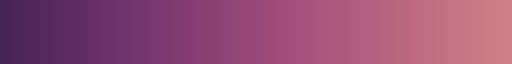

In [2]:
#cmap = sns.cubehelix_palette(start=1.0, rot=-1.0, light=0.8, dark=0.2, hue=1.0, reverse=True, as_cmap=True)
cmap = sns.cubehelix_palette(start=3.0, rot=0.5, light=0.6, dark=0.2, hue=1.0, reverse=True, as_cmap=True)
#cmap = sns.cubehelix_palette(start=0.0, rot=0.0, light=0.7, dark=0.3, hue=1.0, reverse=True, as_cmap=True)
#cmap = sns.cubehelix_palette(start=0.5, rot=0.0, light=0.7, dark=0.3, hue=1.0, reverse=True, as_cmap=True)

cmap

In [3]:
def gnomic(mu_ra, mu_dec, ra, dec):
    """
    https://mathworld.wolfram.com/GnomonicProjection.html
    The Gnomic projection is a conformal (angle-preserving) map of 
    coordinates on a sphere to coordinates on a plane around some central
    coordinate.
    """
    mu_ra = np.deg2rad(mu_ra)
    mu_dec = np.deg2rad(mu_dec)
    ra = np.deg2rad(ra)
    dec = np.deg2rad(dec)
    
    cos_c = np.sin(mu_dec) * np.sin(dec) + np.cos(mu_dec) * np.cos(dec) * np.sin(ra - mu_ra)
    x = np.cos(dec) * np.sin(ra - mu_ra) / cos_c
    y = (np.cos(mu_dec) * np.sin(dec) - np.sin(mu_dec) *np.cos(dec) * np.cos(ra - mu_ra)) / cos_c
    
    return x, y

In [37]:
def plots(position, real_data, sim_data, merged_data, cmap):
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
    
    hb = axs[0].hexbin(real_data['ra'], real_data['dec'], mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[0])
    # axs[0].scatter(0, 0, c='r', marker='+', s=200)
    axs[0].set_title('DC2 Data')
    axs[0].set_xlabel(r'$ra$')
    axs[0].set_ylabel(r'$dec$')

    hb = axs[1].hexbin(sim_data['ra'], sim_data['dec'], mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[1])
    # axs[1].scatter(0, 0, c='r', marker='+', s=200)
    axs[1].set_title(f'Simulated Satellite {mcid}')
    axs[1].set_xlabel(r'$ra$')
    axs[1].set_ylabel(r'$dec$')

    hb = axs[2].hexbin(merged_data['ra'], merged_data['dec'], mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[2])
    # axs[2].scatter(0, 0, c='r', marker='+', s=200)
    axs[2].set_title('Merged')
    axs[2].set_xlabel(r'$ra$')
    axs[2].set_ylabel(r'$dec$')

    plot_cmd(merged_data, axs[3])
    plt.show()

In [5]:
def calc_survey(dist,survey='des'):
    if survey == 'des':
        #    Dist   A0     Mv0    logr0
        P0=[[11.3 ,  21.5,   7.8 ,   3.8],
            [22.6 ,  24.1,   8.3 ,   4.2],
            [45.2 ,  17.2,   5.2 ,   4.3], #tuned
            [90.5 ,  8.6 ,   1.2 ,   4.1],
            [181.0,  6.6 ,   -1.1,   4.1],
            [362.0,  6.3 ,   -2.3,   4.3]]
        #P0=[[11.3 ,  23.1 ,  8.1  ,  3.9  ],
        #    [22.6 ,  19.9 ,  7.3  ,  4.1  ],
        #    [45.2 ,  21.1 ,  6.1  ,  4.5  ],
        #    [90.5 ,  8.8  ,  1.2  ,  4.1  ],
        #    [181.0,  7.9  ,  -0.7 ,  4.2  ],
        #    [362.0,  6.4  ,  -2.2 ,  4.3  ]]
    elif survey == 'ps1':
        #    Dist      A0     Mv0    logr0
        P0=[[11.3 ,  21.7,   6.7 ,   3.9],
            [22.6 ,  16.4,   4.3 ,   4.0],
            [45.2 ,  11.5,   1.0 ,   4.0],
            [90.5 ,  8.6 ,   -1.0,   4.0],
            [181.0,  7.2 ,   -2.4,   4.2],
            [362.0,  4.2 ,   -4.8,   4.0]]
        P0=[[11.3 ,  22.8 ,  7.1  ,  4.0],
            [22.6 ,  19.0 ,  5.0  ,  4.1],
            [45.2 ,  14.1 ,  1.8  ,  4.2],
            [90.5 ,  11.0 ,  -0.3 ,  4.3],
            [181.0,  7.5  ,  -2.2 ,  4.2],
            [362.0,  6.8  ,  -4.0 ,  4.4],]


    #A = normalization factor (how curved)
    #B = Mv0 -- the absolute magnitude cut
    #C = R0  -- the r_physical cut
    PARAMS = np.rec.fromrecords(P0,names=['D','A','B','C'])

    a = np.interp(dist,PARAMS['D'],PARAMS['A'])
    b = np.interp(dist,PARAMS['D'],PARAMS['B'])
    c  = np.interp(dist,PARAMS['D'],PARAMS['C'])

    abs_mag = np.linspace(mbins.min(),mbins.max(),1000)
    r_physical = a/(abs_mag - b) + c

    return abs_mag, r_physical, a, b, c

In [6]:
def setdefaults(kwargs,defaults):
    for k,v in defaults.items():
        kwargs.setdefault(k,v)
    return kwargs

In [7]:
def draw_survey(dist,survey,**kwargs):
    defaults = dict(ls='--',color='k',zorder=1)
    kwargs = setdefaults(kwargs,defaults)
    abs_mag, r_physical,a,b,c = calc_survey(dist,survey)
    sel = abs_mag < b
    plt.plot(abs_mag[sel],r_physical[sel],**kwargs)

In [8]:
def query(service, ra, dec, radius=1.0, gmax=23.5):
    """Return data queried from Rubin TAP
    Parameters
    ----------
    service : TAP service [str]
    ra      : Right Ascension [deg]
    dec     : Declination [deg]
    radius  : radius around (ra, dec) [deg]

    Returns
    -------
    good_results : pd.Dataframe
    """

    # Redenning coefficients
    R_g = 3.185
    R_r = 2.140
    R_i = 1.571
    
    # Define our reference position on the sky and cone radius in arcseconds
    # to use in all following examples
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg
    
    # Quality selection and star--galaxy separation adapted from
    # https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb

    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    mag_threshold = 26

    # assuming extendedness is the same in all bands we assume g_extendedness matches extendedness for dp0.2 tables
    
    safe_max_extended = 1.0
    
    query = f"""
        SELECT
            ra, dec,
            mag_g, mag_r,
            magerr_g, magerr_r,
            mag_g - {R_g} AS mag_corrected_g,
            mag_r - {R_r} AS mag_corrected_r,
            extendedness
        FROM dp01_dc2_catalogs.object
        WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND extendedness < {str(safe_max_extended)}
    """

    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    async_results = job.fetch_result()
    results = async_results.to_table().to_pandas()
    job.delete()

    good_snr = (results['magerr_g'] < mag_err_threshold) & (results['magerr_r'] < mag_err_threshold)
    good_results = results[good_snr]
    
    return good_results

In [9]:
def get_catalog_file(catalog_dir, mc_source_id):
    """
    Inputs:
        catalog_dir = string corresponding to directory containing the stellar catalog infiles
        mc_source_id = integer corresponding the target MC_SOURCE_ID value
    Outputs:
        catalog_infile = string corresponding to filename of stellar catalog containing mc_source_id
    """
    catalog_infiles = sorted(glob.glob(catalog_dir + '/*catalog*.fits'))
    mc_source_id_array = []
    catalog_infile_index_array = []
    for ii, catalog_infile in enumerate(catalog_infiles):
        mc_source_id_min = int(os.path.basename(catalog_infile).split('.')[0].split('mc_source_id_')[-1].split('-')[0])
        mc_source_id_max = int(os.path.basename(catalog_infile).split('.')[0].split('mc_source_id_')[-1].split('-')[1])
        assert (mc_source_id_max > mc_source_id_min) & (mc_source_id_min >= 1), 'Found invalue MC_SOURCE_ID values in filenames'
        mc_source_id_array.append(np.arange(mc_source_id_min, mc_source_id_max + 1))
        catalog_infile_index_array.append(np.tile(ii, 1 + (mc_source_id_max - mc_source_id_min)))

    mc_source_id_array = np.concatenate(mc_source_id_array)
    catalog_infile_index_array = np.concatenate(catalog_infile_index_array)

    assert len(mc_source_id_array) == len(np.unique(mc_source_id_array)), 'Found non-unique MC_SOURCE_ID values in filenames'
    assert np.in1d(mc_source_id, mc_source_id_array), 'Requested MC_SOURCE_ID value not among files'
    mc_source_id_index = np.nonzero(mc_source_id == mc_source_id_array)[0][0] # second [0] added by smau 7/23/18 to fix incompatiable type bug
    return catalog_infiles[catalog_infile_index_array[mc_source_id_index]]

In [10]:
def load_sim_data(sim_dir, mc_source_id):
    """
    Load info for injecting satellite sims
    """
    cat_file = get_catalog_file(sim_dir, mc_source_id)
    cat_fits = fits.FITS(cat_file)
    w = cat_fits[1].where(f'MC_SOURCE_ID == {mc_source_id}')
    try:       
        data = cat_fits[1][w]
        cat_fits.close()
        return data
    except IndexError: 
        print('Array is empty')
        
    return

In [34]:
def plot_cmd(data, axs):
    """Plot a color magnitude diagram.
    
    data: DataFrame with photometry data
    """
    y = data['mag_g']  
    x = data['mag_g'] - data['mag_r']
    
    xlims = [-1, 1.5]  #need to find better way to restrict axes
    ylims = [16,28]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$Magnitude (g)$')
    axs.set_xlabel('$Color (g-r)$')
    
    axs.plot(x, y, 'ko', markersize=0.3, alpha=0.3)
    axs.invert_yaxis()

    
    plt.show()
    
    return

In [12]:
# Note that this query (which uses the truth information about star--galaxy separation) is much slower
def query_RSP_truth(service, ra, dec, radius=1):
    # Define our reference position on the sky and cone radius in arcseconds
    # to use in all following examples
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg

    query = f"""
        SELECT
            obj.ra, obj.dec,
            obj.mag_g, obj.mag_r,
            obj.magerr_g, obj.magerr_r,
            obj.mag_g as mag_corrected_g, obj.mag_r as mag_corrected_r,
            obj.extendedness as extended_class
        FROM dp01_dc2_catalogs.object as obj
        JOIN dp01_dc2_catalogs.truth_match as truth
        ON truth.match_objectId = obj.objectId
        WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND obj.extendedness < 1
        AND truth.match_objectId >= 0 
        AND truth.is_good_match = 1
        AND truth.truth_type = 2
    """
    
    df = service.search(query).to_table().to_pandas()
    df['MC_SOURCE_ID'] = 0
    
    return df

In [13]:
from lsst.rsp import get_tap_service

service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

In [31]:
df1 = query_RSP_truth(service, 50, -40)
df2 = query(service, 50, -40)

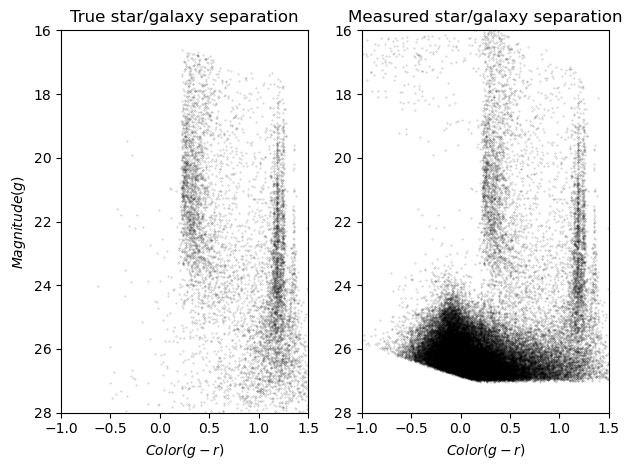

In [32]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
axs[0].set_title("True star/galaxy separation")
axs[0].set_ylabel('$Magnitude (g)$')
plot_cmd(df1, axs[0])
axs[1].set_title("Measured star/galaxy separation")
plot_cmd(df2, axs[1])
plt.tight_layout()

In [14]:
_data_cache = None

In [35]:
sim_dir = '/project/shared/data/satsim/lsst_dc2_v7' 
population_file = glob.glob(os.path.join(sim_dir, '*population*'))

0019601-0019700
Files testing_true_extensions/sim_pop_0019601-0019700.csv already processed
0050701-0050800
Querying region (50.814877, -42.201397)
Satellites at  (50.814877, -42.201397) :
 [50741 50743 50744 50745 50746 50748 50749]


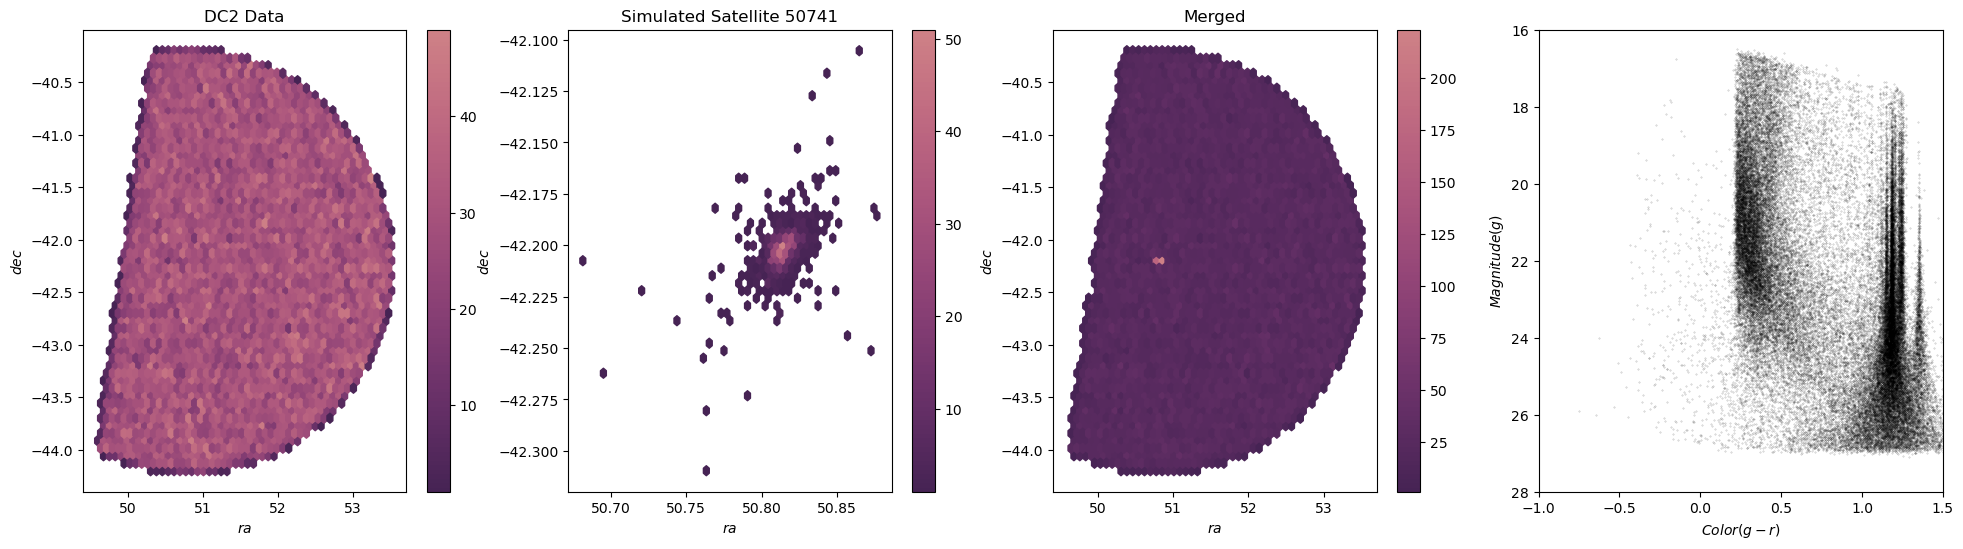

Searching for: MC_SOURCE_ID  50741


/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.005, r_peak:        0.038, sig:       37.500, ra_peak:       50.808, dec_peak:      -42.206
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.575, r_peak:        0.600, sig:        7.272, ra_peak:       50.767, dec_peak:      -42.776
Fitting aperture to hotspot...
Characteristic density local = 1476.2 deg^-2 = 0.410 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -0.745, r_peak:        0.822, sig:        7.294, ra_peak:       51.177, dec_peak:      -42.946
Fitting aperture to hotspot...
Characteristic density local = 1514.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -1.265, r_peak:        0.000, sig:        3.174, ra_peak:       51.690, dec_peak:      -43.463
Fitting aperture 

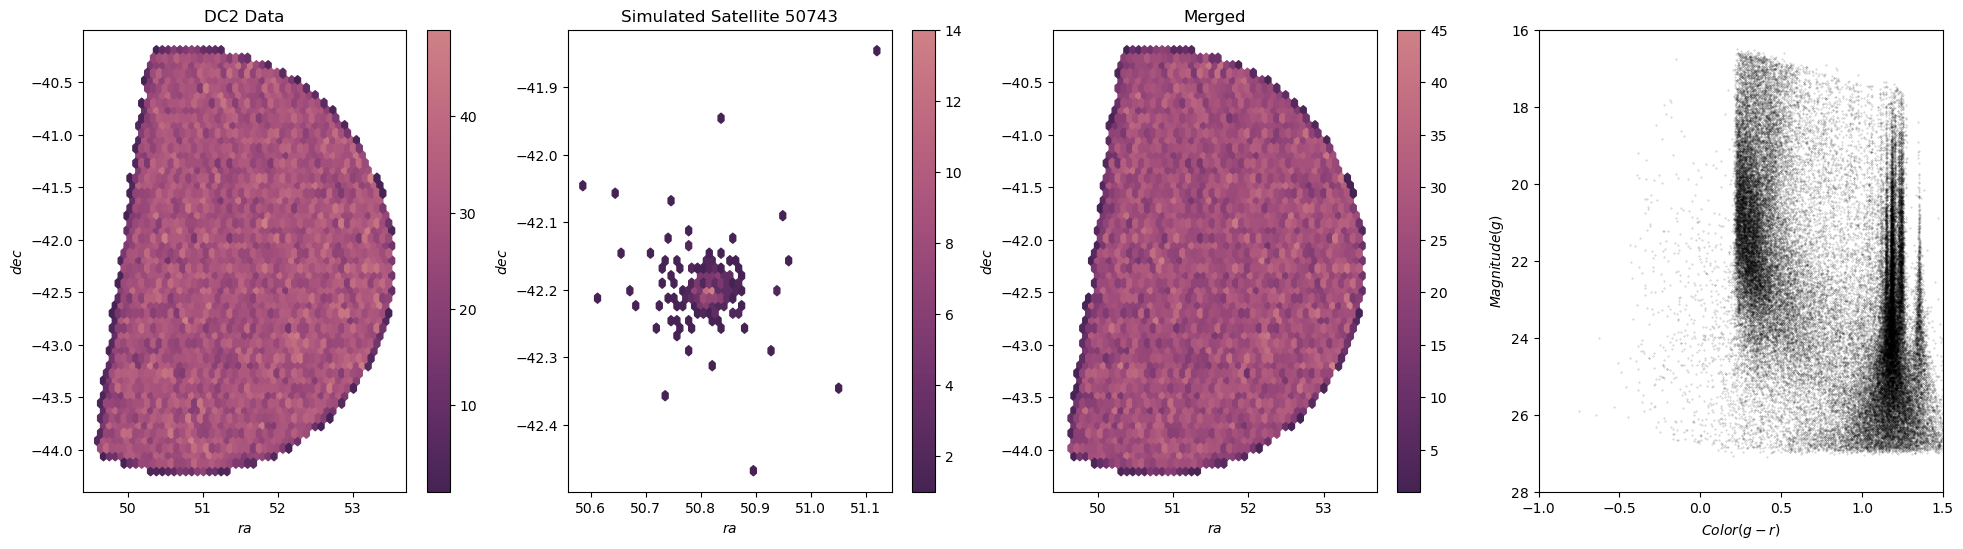

Searching for: MC_SOURCE_ID  50743


/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):


Characteristic density = 400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 443.6 deg^-2 = 0.123 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        0.005, r_peak:        0.029, sig:        9.867, ra_peak:       50.822, dec_peak:      -42.196
Fitting aperture to hotspot...
Characteristic density local = 400.0 deg^-2 = 0.111 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.725, r_peak:        0.038, sig:        4.057, ra_peak:       50.822, dec_peak:      -43.926
Fitting aperture to hotspot...
Characteristic density local = 364.1 deg^-2 = 0.101 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.945, r_peak:        0.000, sig:        3.567, ra_peak:       50.945, dec_peak:      -43.146
Fitting aperture to hotspot...
Characteristic density local = 400.0 deg^-2 = 0.111 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -1.705, r_peak:        0.003, sig:        3.737, ra_peak:       51.016, dec_peak:      -43.906
Fitting aperture to ho

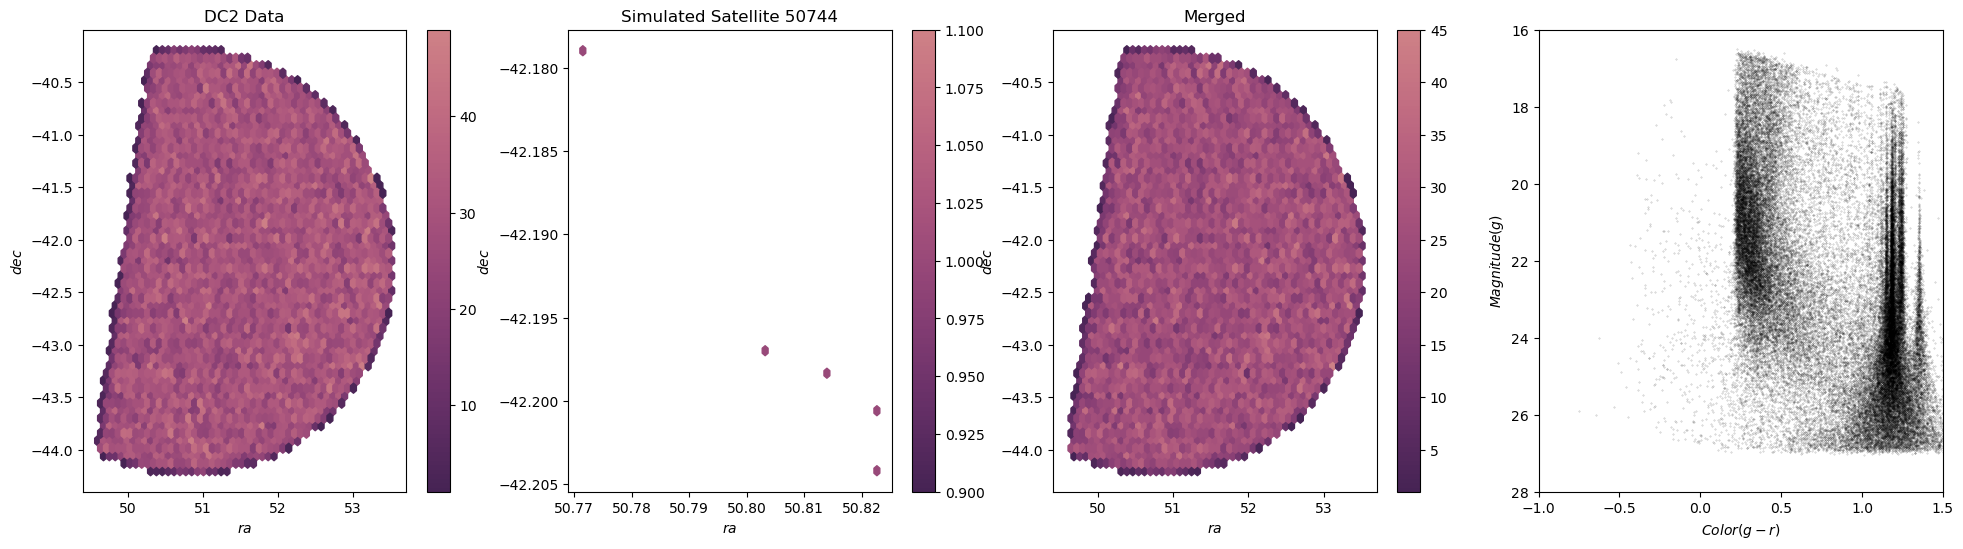

Searching for: MC_SOURCE_ID  50744


/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):


Characteristic density = 400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 400.0 deg^-2 = 0.111 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.735, r_peak:        0.027, sig:        4.447, ra_peak:       50.822, dec_peak:      -43.936
Fitting aperture to hotspot...
Characteristic density local = 409.8 deg^-2 = 0.114 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.205, r_peak:        0.038, sig:        4.010, ra_peak:       50.767, dec_peak:      -42.406
Fitting aperture to hotspot...
Characteristic density local = 370.0 deg^-2 = 0.103 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.945, r_peak:        0.000, sig:        3.563, ra_peak:       50.945, dec_peak:      -43.146
Fitting aperture to hotspot...
Characteristic density local = 400.0 deg^-2 = 0.111 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -1.705, r_peak:        0.003, sig:        3.737, ra_peak:       51.016, dec_peak:      -43.906
Fitting aperture to ho

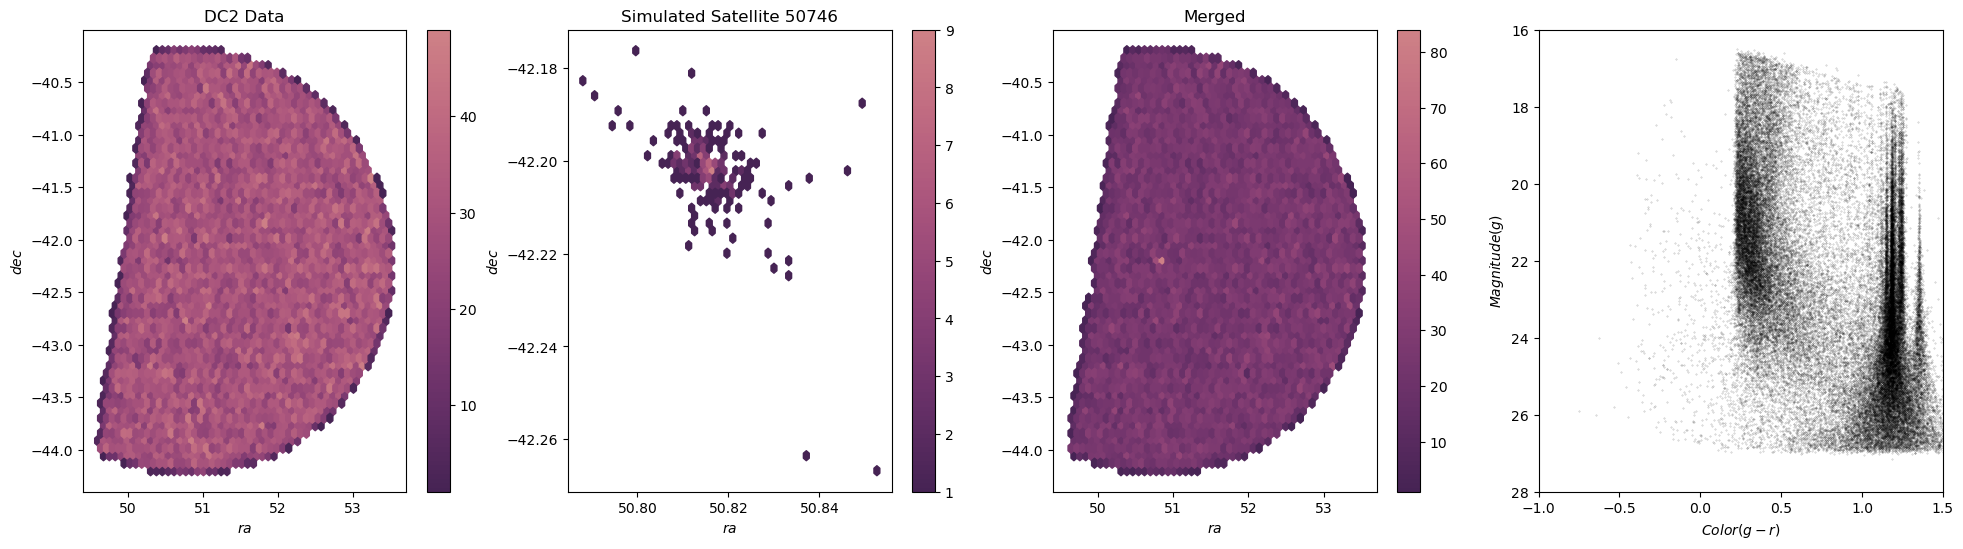

Searching for: MC_SOURCE_ID  50746


/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):


Characteristic density = 900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 900.0 deg^-2 = 0.250 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.725, r_peak:        0.034, sig:        4.626, ra_peak:       49.948, dec_peak:      -42.923
Fitting aperture to hotspot...
Characteristic density local = 779.9 deg^-2 = 0.217 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.965, r_peak:        0.053, sig:        4.291, ra_peak:       50.287, dec_peak:      -43.165
Fitting aperture to hotspot...
Characteristic density local = 1080.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.465, r_peak:        0.000, sig:        3.271, ra_peak:       50.726, dec_peak:      -42.666
Fitting aperture to hotspot...
Characteristic density local = 1010.6 deg^-2 = 0.281 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.005, r_peak:        0.015, sig:       22.324, ra_peak:       50.822, dec_peak:      -42.206
Fitting aperture to 

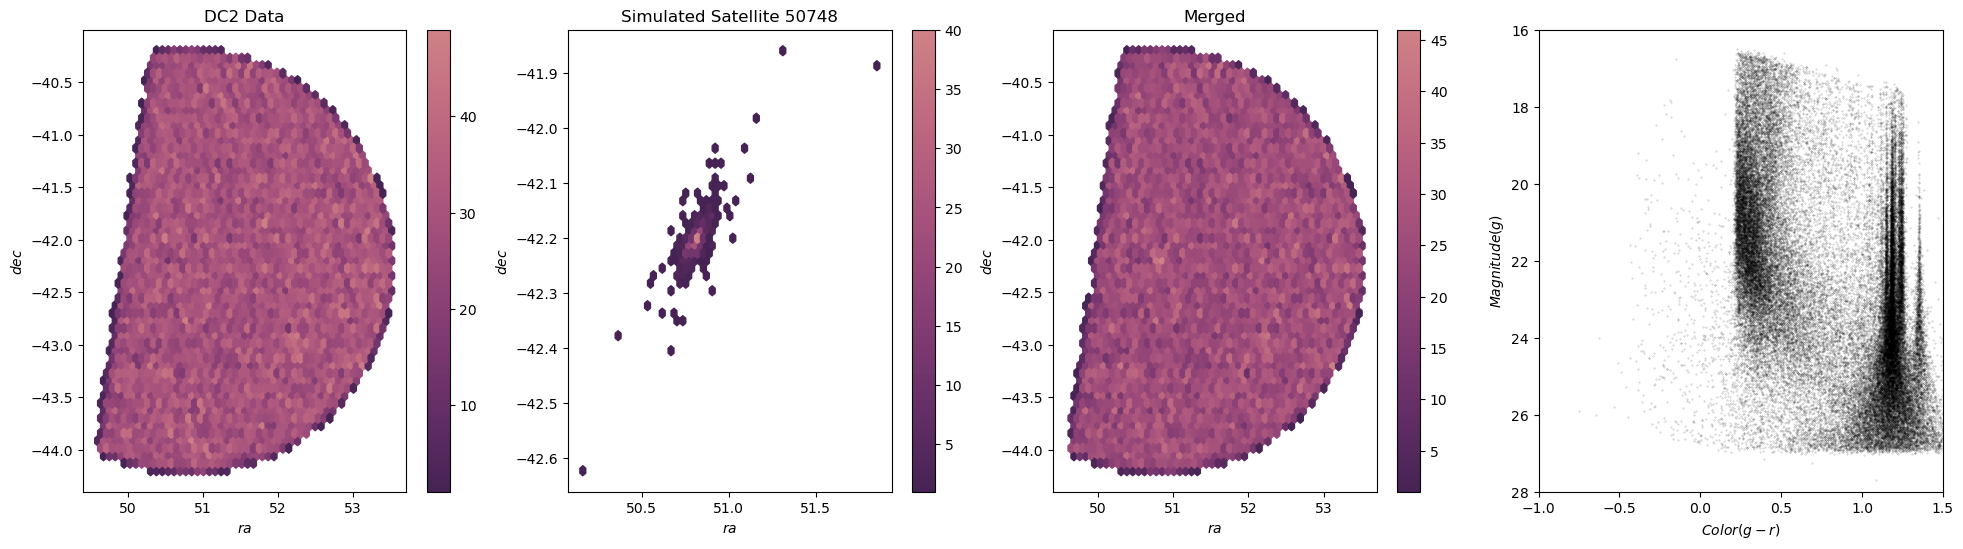

Searching for: MC_SOURCE_ID  50748


/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):


Characteristic density = 400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 400.0 deg^-2 = 0.111 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -0.485, r_peak:        0.017, sig:        4.646, ra_peak:       50.196, dec_peak:      -42.685
Fitting aperture to hotspot...
Characteristic density local = 519.2 deg^-2 = 0.144 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.445, r_peak:        0.000, sig:        3.473, ra_peak:       50.686, dec_peak:      -42.646
Fitting aperture to hotspot...
Characteristic density local = 491.4 deg^-2 = 0.136 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.005, r_peak:        0.080, sig:       10.006, ra_peak:       50.808, dec_peak:      -42.206
Fitting aperture to hotspot...
Characteristic density local = 467.5 deg^-2 = 0.130 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.105, r_peak:        0.187, sig:        5.833, ra_peak:       50.700, dec_peak:      -42.096
Fitting aperture to ho

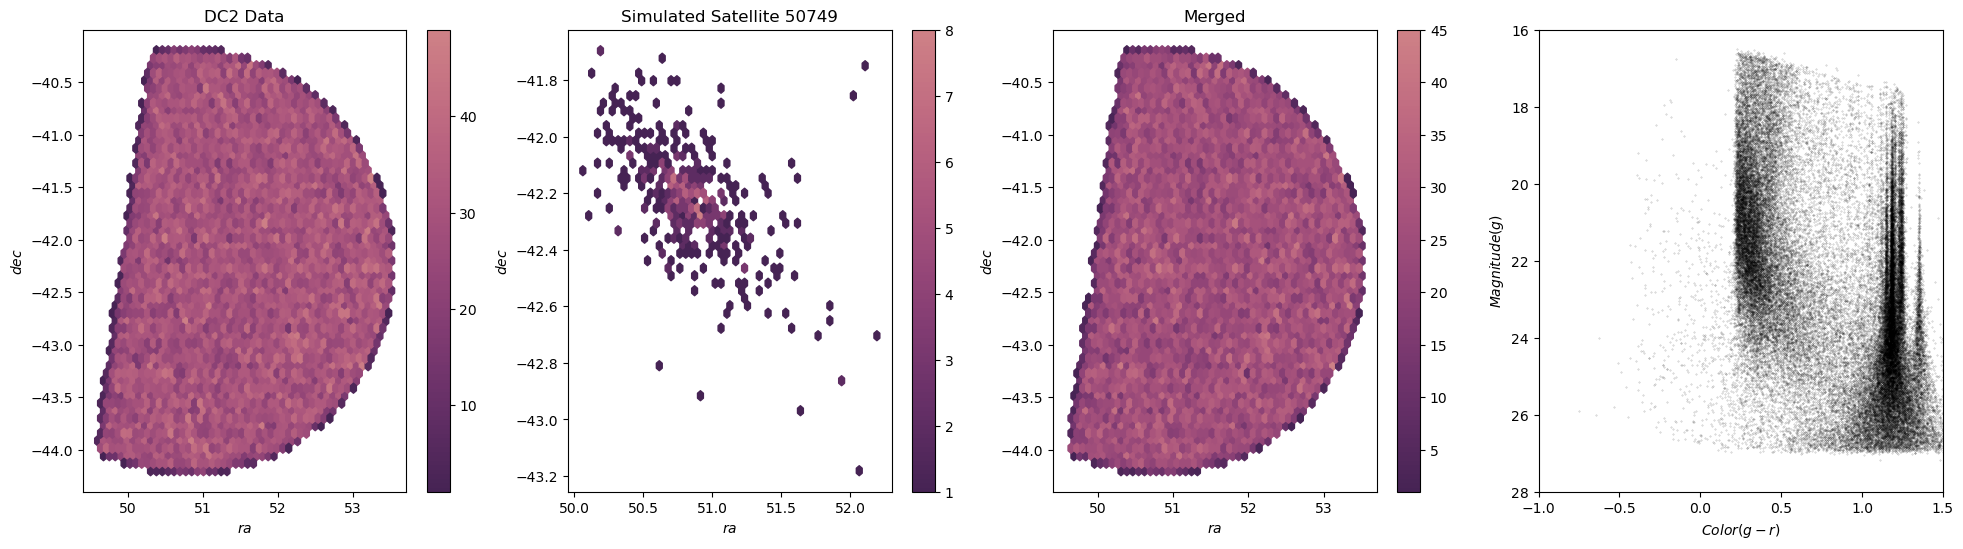

Searching for: MC_SOURCE_ID  50749


/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.075, r_peak:        0.187, sig:        5.800, ra_peak:       50.849, dec_peak:      -42.276
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -1.825, r_peak:        0.000, sig:        3.241, ra_peak:       49.987, dec_peak:      -44.024
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.375, r_peak:        0.000, sig:        3.241, ra_peak:       50.048, dec_peak:      -42.574
Fitting aperture to hotspot...
Characteristic density local = 1084.2 deg^-2 = 0.301 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -1.235, r_peak:        0.327, sig:        3.527, ra_peak:       50.230, dec_peak:      -43.435
Fitting aperture 

KeyboardInterrupt: 

In [38]:
for file in population_file:
    name = file
    start = name.find('0')
    end = start + 15
    mcids = name[start:end]
    print(mcids)
    outfile = f'testing_true_extensions/sim_pop_{mcids}.csv'
    if os.path.exists(f'results_dir/{outfile}'):
        print(f'Files {outfile} already processed')
        continue

    with open('config.yaml') as ymlfile:
        cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
        survey = simple_adl.survey.Survey(cfg)

    sim_population = fits.read(file)
    sim_positions = np.unique(sim_population[['RA', 'DEC']])
    sim_population  = sim_population.byteswap().newbyteorder()    # resetting byte order for compatibility
    sim_population = sim_population[sim_population['FRACDET_CORE'] == 1]
    sim_population = sim_population[sim_population['FRACDET_WIDE'] == 1]
    sim_population = sim_population[sim_population['FRACDET_HALF'] == 1]
    radius = 2

    for iii,position in enumerate(sim_positions):
        sim_population_at_position = sim_population[sim_population[['RA', 'DEC']] == position]
        t = pd.DataFrame(sim_population_at_position)
        if len(t['MC_SOURCE_ID'].values) == 0:
            print(f'No sims at {position}')
            continue
        print(f'Querying region {position}')
        real_data = query_RSP_truth(service, position[0], position[1], radius)  # pd.DataFrame
        print('Satellites at ', position, ':\n', t['MC_SOURCE_ID'].values)
        for mcid in sim_population_at_position['MC_SOURCE_ID']:
            sim_data = load_sim_data(sim_dir, mcid)
            if sim_data is not None:
                sim_data = sim_data.byteswap().newbyteorder()   # resetting byte order for compatibility
                sim_data = pd.DataFrame(sim_data)               # convert to pd.DataFrame
                # mask to ensure we only use sims within the queried data's footprint

                c2 = SkyCoord(sim_data['ra'], sim_data['dec'], unit='deg', frame='icrs')
                center = SkyCoord(position[0], position[1], unit='deg')
                d2d = center.separation(c2) 
                catalogmsk = d2d < radius*u.deg
                sim_data = sim_data[catalogmsk]

                if sim_data.empty:
                    print(f'No sim data to inject into region at ({position[0]},{position[1]}) after applying mask')
                    continue

                # merging the sims and dc2 data
                frames = [real_data[real_data.columns[:-1]], sim_data[real_data.columns[:-1]]]
                merged_data = pd.concat(frames)  # pd.Dataframe
                # perform mag cut on the merged data
                good_snr = (merged_data['magerr_g'] < 0.2) & (merged_data['magerr_r'] < 0.2)
                merged_data = merged_data[good_snr]
                #good_mag = (merged_data['mag_g'] < 23) & (merged_data['mag_r'] < 23)
                #merged_data = merged_data[good_mag]
                
                plots(position, real_data, sim_data, merged_data, cmap)

                print('Searching for: MC_SOURCE_ID ', mcid)

                ra = position[0]
                dec = position[1]
                region = simple_adl.survey.Region(survey, ra, dec)
                region.data = merged_data

                # Scan in distance moduli    
                distance_modulus = t.loc[t['MC_SOURCE_ID'] == mcid]['DISTANCE_MODULUS']
                distance_modulus = distance_modulus.values[0]
                iso_search = simple_adl.isochrone.Isochrone(survey=survey.isochrone['survey'],
                                                       band_1=survey.band_1.lower(),
                                                       band_2=survey.band_2.lower(),
                                                       age=12.0, #survey.isochrone['age'],
                                                       metallicity=0.00010, #survey.isochrone['metallicity'],
                                                       distance_modulus=distance_modulus)

                iso_selection = cut_isochrone_path(region.data[survey.mag_dered_1], 
                                                      region.data[survey.mag_dered_2],
                                                      region.data[survey.mag_err_1],
                                                      region.data[survey.mag_err_2],
                                                      iso_search,
                                                      survey.catalog['mag_max'],
                                                      radius=0.1)

                results = search_by_distance(survey, region, distance_modulus, iso_selection, sim_population['EXTENSION']) 
                ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, distance_modulus_array, n_obs_peak_array, n_obs_half_peak_array, n_model_peak_array = np.asarray(results)
                best_ra_peak, best_dec_peak, best_r_peak, best_distance_modulus, n_obs_peak, n_obs_half_peak, n_model_peak, best_sig_peak = 0, 0, 0, 0, 0, 0, 0, 0

                if mcid: 
                    mc_source_id_array = np.full_like(distance_modulus_array, mcid)
                else:
                    mc_source_id_array = np.zeros(len(distance_modulus_array))

                # Sort peaks according to significance
                index_sort = np.argsort(sig_peak_array)[::-1]
                ra_peak_array = ra_peak_array[index_sort]
                dec_peak_array = dec_peak_array[index_sort]
                r_peak_array = r_peak_array[index_sort]
                sig_peak_array = sig_peak_array[index_sort]
                distance_modulus_array = distance_modulus_array[index_sort]
                n_obs_peak_array = n_obs_peak_array[index_sort]
                n_obs_half_peak_array = n_obs_half_peak_array[index_sort]
                n_model_peak_array = n_model_peak_array[index_sort]
                mc_source_id_array = mc_source_id_array[index_sort]

                # Collect overlapping peaks
                for ii in range(0, len(sig_peak_array)):
                    if sig_peak_array[ii] < 0:
                        continue
                    sep = angsep(ra_peak_array[ii], dec_peak_array[ii], ra_peak_array, dec_peak_array)
                    sig_peak_array[(sep < r_peak_array[ii]) & (np.arange(len(sig_peak_array)) > ii)] = -1.

                # Prune the list of peaks
                ra_peak_array = ra_peak_array[sig_peak_array > 0.]
                dec_peak_array = dec_peak_array[sig_peak_array > 0.]
                r_peak_array = r_peak_array[sig_peak_array > 0.]
                distance_modulus_array = distance_modulus_array[sig_peak_array > 0.]
                n_obs_peak_array = n_obs_peak_array[sig_peak_array > 0.]
                n_obs_half_peak_array = n_obs_half_peak_array[sig_peak_array > 0.]
                n_model_peak_array = n_model_peak_array[sig_peak_array > 0.]
                mc_source_id_array = mc_source_id_array[sig_peak_array > 0.]
                sig_peak_array = sig_peak_array[sig_peak_array > 0.] # Update the sig_peak_array last!

                if sig_peak_array[0] > best_sig_peak:
                    best_sig_peak = sig_peak_array[0]
                    best_ra_peak = ra_peak_array[0]
                    best_dec_peak = dec_peak_array[0]
                    best_r_peak = r_peak_array[0]
                    best_distance_modulus = distance_modulus_array[0]
                    n_obs_peak = n_obs_peak_array[0]
                    n_obs_half_peak = n_obs_half_peak_array[0]
                    n_model_peak = n_model_peak_array[0]
                    mc_source_id = mc_source_id_array[0]

                del merged_data
                
                for ii in range(0, len(sig_peak_array)):
                    print('{:0.2f} sigma; (RA, Dec) = ({:0.2f}, {:0.2f}); r = {:0.2f} deg; d = {:0.1f}, mu = {:0.2f} mag, mc_source_id: {:0.2f}'.format(sig_peak_array[ii], 
                             ra_peak_array[ii], 
                             dec_peak_array[ii], 
                             r_peak_array[ii],
                             distanceModulusToDistance(distance_modulus_array[ii]),
                             distance_modulus_array[ii],
                             mc_source_id_array[ii]))  

                if best_sig_peak < 9:
                    print(f'--> {mcid} NOT FOUND')
                    print('---------------------------------')
                    try:
                        if (len(sig_peak_array) > 0):
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center, best_ra_peak, best_dec_peak,
                                            best_r_peak, best_distance_modulus, 
                                            n_obs_peak, n_obs_half_peak, n_model_peak, 
                                            best_sig_peak, mcid, 0, outfile)
                        else:
                            print('No significant hotspots found.')
                            nan_array = [np.nan]
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center,
                                             nan_array, nan_array, nan_array, nan_array, 
                                             nan_array, nan_array, nan_array, nan_array,
                                             [mc_source_id], 0, outfile)
                    except Exception as e: 
                        print(e)
                        print('Data missing, cannot write to file')

                else:   
                    print(f'--> {mcid} FOUND')
                    print('---------------------------------')
                    try:
                        if (len(sig_peak_array) > 0):
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center, best_ra_peak, best_dec_peak,
                                            best_r_peak, best_distance_modulus, 
                                            n_obs_peak, n_obs_half_peak, n_model_peak, 
                                            best_sig_peak, mcid, 0, outfile)
                        else:
                            print('No significant hotspots found.')
                            nan_array = [np.nan]
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center,
                                             nan_array, nan_array, nan_array, nan_array, 
                                             nan_array, nan_array, nan_array, nan_array,
                                             [mc_source_id], 0, outfile)
                    except Exception as e: 
                        print(e)
                        print('Data missing, cannot write to file')

In [34]:
importlib.reload(simple_adl.survey)

<module 'simple_adl.survey' from '/home/kabelo-t/software/simple_adl/simple_adl/survey.py'>

In [15]:
#setting up sim dataframe
sim_dir = '/project/shared/data/satsim/lsst_dc2_v7'      #perfect star/galaxy separation
population_file = glob.glob(os.path.join(sim_dir, '*population*'))

files = glob.glob("results_dir/testing_true_extensions/*.csv")
first_file = files[0]
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)
file_ids = [files[8:23] for files in os.listdir('results_dir/testing_true_extensions') if 'ipynb' not in files]

for i,f in enumerate(population_file):
    if i == 0:
        continue
    for ids in file_ids:
        if ids in f:
            sim_pop = fits.read(f)
            sim_pop = sim_pop.byteswap().newbyteorder()
            df2 = pd.DataFrame(sim_pop)
            df1 = pd.concat((df1,df2), ignore_index=True)
            break
            
datadf = read_csv(first_file)
for f in files:
    if f == first_file:
        continue
    df3 = pd.read_csv(f)
    datadf = pd.concat((datadf, df3), ignore_index=True)
    
v7 = pd.merge(df1,datadf[['MC_SOURCE_ID','SIG', 'R']],on='MC_SOURCE_ID',how='left')         #merge
v7 = v7[v7['FRACDET_CORE'] == 1]
v7 = v7[v7['FRACDET_WIDE'] == 1]
v7 = v7[v7['FRACDET_HALF'] == 1]
v7.loc[v7.DIFFICULTY == 2, 'SIG'] = 37.5
v7.dropna(inplace=True)

In [81]:
type(im[3])

matplotlib.collections.QuadMesh

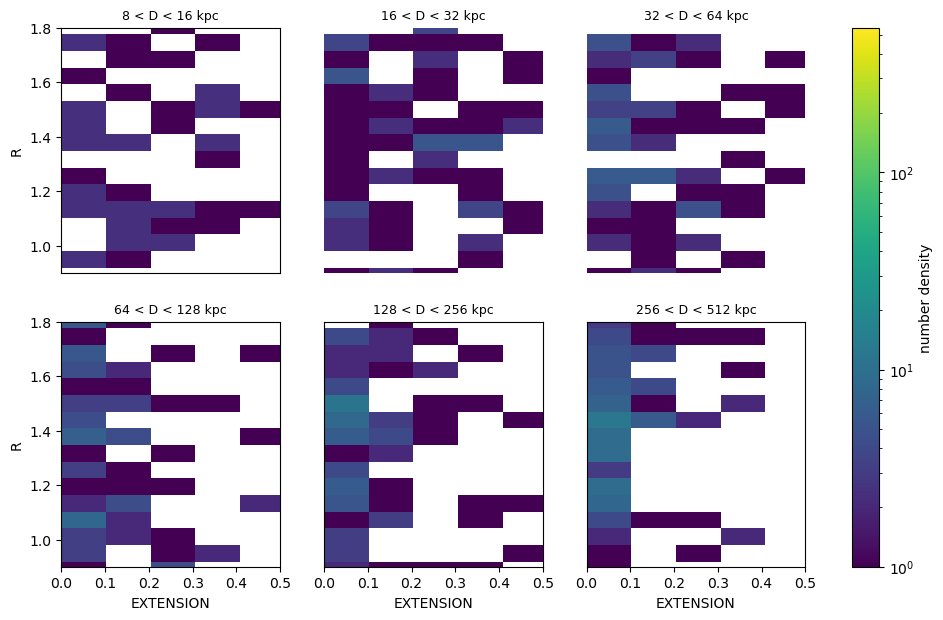

In [41]:
dbins = 2**np.arange(3,10)
fig,axes = plt.subplots(2,3,figsize=(12,7))
axes[0,0].axes.get_xaxis().set_visible(False)
axes[0,1].axis('off')
axes[0,2].axis('off')
axes[1,2].axes.get_yaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
nbins = 50
for i,(dmin,dmax) in enumerate(zip(dbins[:-1],dbins[1:])):
    plt.sca(axes.flat[i]) 
    plt.title("%i < D < %i kpc"%(dmin,dmax), fontsize=9)
    plt.xlabel('EXTENSION')
    plt.ylabel('R') 
    s = v7[(v7['DISTANCE'] >= dmin)&(v7['DISTANCE'] < dmax)]
    im = plt.hist2d(s['EXTENSION'].values, s['R'].values, bins=[np.linspace(0, 5, nbins), np.linspace(0, 3, nbins)], norm=LogNorm())
    plt.xlim(0, 0.5)
    plt.ylim(0.9, 1.8)  
    
cb = fig.colorbar(im[3], ax=axes.ravel().tolist(), label='number density')

NameError: name 'sims' is not defined

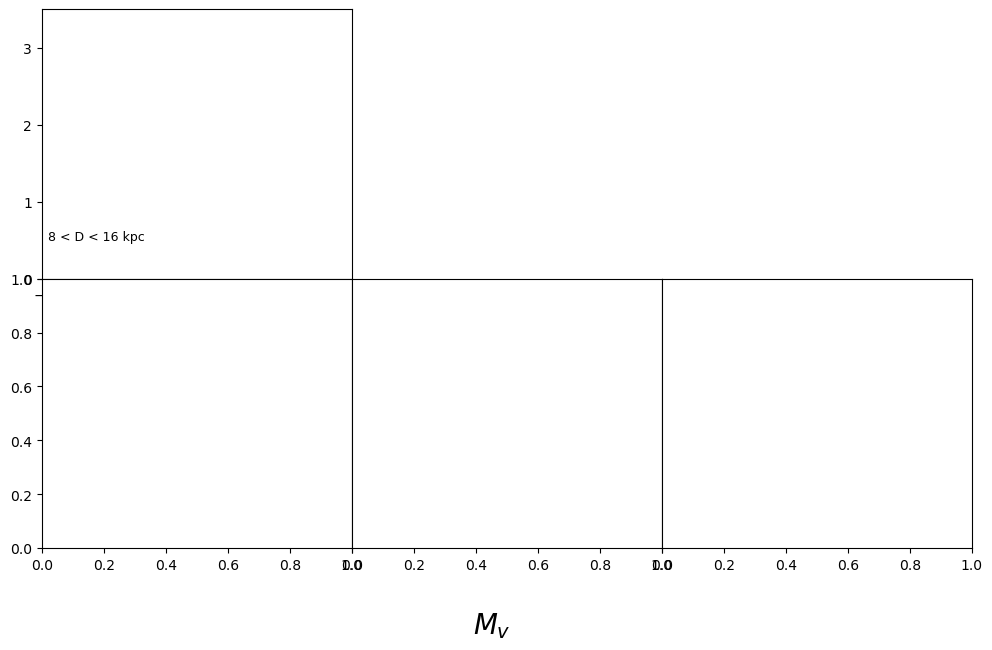

In [63]:
# bins in distance
dbins = 2**np.arange(3,10)
# bins in absolute magnitude
mbins = np.arange(-11,2.5,0.75)
# bins in physical radius
rbins = np.arange(0,3.75,0.35)

#jeff's file
pars = pd.read_csv('results_dir/MW_dwarfs_limiting_MV.csv')
#pars = pars.values
fig,axes = plt.subplots(2,3,figsize=(12,7))
plt.subplots_adjust(wspace=0, hspace=0)
axes[0,1].axis('off')
axes[0,2].axis('off')
axes[1,2].axes.get_yaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
fig.text(0.5, 0, '$ M_{v} $', ha='center', va='center', fontsize=20)

for i,(dmin,dmax) in enumerate(zip(dbins[:-1],dbins[1:])):
    plt.sca(axes.flat[i])
    plt.text(-10, 0.5, "%i < D < %i kpc"%(dmin,dmax), fontsize=9, )
    plt.xlim(-10.25,1.75)
    plt.ylim(0, 3.5)
    plt.yticks(np.arange(0, 4, 1))
    plt.plot(0, 2)
    s = sims[(sims['DISTANCE'] >= dmin)&(sims['DISTANCE'] < dmax)]

    det = s["SIG"] >= 5.5

    total = np.histogram2d(s['ABS_MAG'],np.log10(s['R_PHYSICAL']*1e3),
                       bins=[mbins,rbins])[0]
    ndet = np.histogram2d(s['ABS_MAG'],np.log10(s['R_PHYSICAL']*1e3),
                       weights=det,bins=[mbins,rbins])[0]

    pdet = ndet.astype(float)/total
    im = plt.pcolormesh(mbins,rbins,pdet.T,rasterized=True)
    p = pars.loc[(pars['dist_kpc'] == dmax)]
    plt.plot(p['M_V'], np.log10(p['rhalf_pc']), color='red', linestyle='dashed')    

cb = fig.colorbar(im, ax=axes.ravel().tolist(), label='Detection Efficiency')

In [15]:
def plot_cmd_sep(rdata, sdata, axs):
    """Plot a color magnitude diagram.
    
    data: merged_data DataFrame with photometry data
    """
    y = rdata['mag_g']  
    x = rdata['mag_g'] - rdata['mag_r']
    
    xlims = [-1, 1.5]  #need to find better way to restrict axes
    ylims = [16,28]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$Magnitude (g)$')
    axs.set_xlabel('$Color (g-r)$')
    
    axs.plot(x, y, 'ko', markersize=0.3, alpha=0.3)
    y = sdata['mag_g']  
    x = sdata['mag_g'] - sdata['mag_r']
    axs.plot(x, y, 'ro', markersize=0.3, alpha=0.3)
    axs.invert_yaxis()

    
    plt.show()
    
    return


In [111]:
pd.set_option("display.max_columns", None)

In [24]:
_data_cache = None

In [ ]:
""" We need to understand the behavior at the faint end at large distances
1. Compare r vs extension and see if there is a diveregence at some distance. 
2. Re run the search with the true extensions being fed to simple
"""

In [100]:
#quicksims dataframe
sim_dir = '/project/shared/data/satsim/lsst_dc2_v7' 
population_file = glob.glob(os.path.join(sim_dir, '*population*'))
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)

for i,f in enumerate(population_file):
    if i == 0:
        continue
    sim_pop = fits.read(f)
    sim_pop = sim_pop.byteswap().newbyteorder()
    df2 = pd.DataFrame(sim_pop)
    df1 = pd.concat((df1,df2), ignore_index=True)
    
qsims = pd.read_csv('results_dir/quick_results_lsst_dc2_v7.csv')
qsims.rename(columns={'mc_source_id':'MC_SOURCE_ID', 
                      'distance':'DISTANCE',
                      'n_obs':'N_OBS',
                      'n_model':'N_MODEL',
                      'sig':'SIG',
                      'r_physical':'R_PHYSICAL',
                      'abs_mag':'ABS_MAG'}, inplace=True)

sims = pd.merge(df1,qsims[['MC_SOURCE_ID','SIG']],on='MC_SOURCE_ID',how='right')         #merge
#sims = sims[sims['FRACDET_CORE'] == 1]
#sims = sims[sims['FRACDET_WIDE'] == 1]
#sims = sims[sims['FRACDET_HALF'] == 1]
sims.loc[sims.DIFFICULTY == 2, 'SIG'] = 37.5

In [70]:
files = glob.glob("results_dir/perfect/*.csv")
first_file = files[0]
sim_pop = fits.read(population_file[0])
sim_pop = sim_pop.byteswap().newbyteorder() 
df1 = pd.DataFrame(sim_pop)
file_ids = [files[8:23] for files in os.listdir('results_dir/perfect') if 'ipynb' not in files]
datadf = read_csv(first_file)
for f in files:
    if f == first_file:
        continue
    df3 = read_csv(f)
    datadf = pd.concat((datadf, df3), ignore_index=True)

### star galaxy efficiency plots

In [34]:
# Note that this query (which uses the truth information about star--galaxy separation) is much slower
def custom_query(service, ra=56.860588, dec = -41.548298, radius=1):
    """Return data queried from Rubin TAP using true star-galaxy separation
    Parameters
    ----------
    service : TAP service [str]
    ra      : Right Ascension [deg]
    dec     : Declination [deg]
    radius  : radius around (ra, dec) [deg]

    Returns
    -------
    df (pd.Dataframe): data from Rubin TAP
    """

    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg
    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    
    query = f"""
        SELECT
            obj.ra, obj.dec,
            obj.mag_g, obj.mag_r,
            obj.magerr_g, obj.magerr_r,
            obj.mag_g as mag_corrected_g, obj.mag_r as mag_corrected_r,
            obj.extendedness as extended_class
        FROM dp01_dc2_catalogs.object as obj
        JOIN dp01_dc2_catalogs.truth_match as truth
        ON truth.match_objectId = obj.objectId
        WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND truth.match_objectId >= 0 
        AND truth.is_good_match = 1
        AND obj.extendedness < 1
        AND truth.truth_type = 2
    """
    
    results = service.search(query).to_table().to_pandas()

    good_snr = (results['magerr_g'] < mag_err_threshold) & (results['magerr_r'] < mag_err_threshold)
    good_results = results[good_snr]
    
    return good_results

In [38]:
match_stars_class = custom_query(service)
match_stars_class

,ra,dec,mag_g,mag_r,magerr_g,magerr_r,mag_corrected_g,mag_corrected_r,extended_class
0,55.950263,-41.995340,23.099155,22.455389,0.007483,0.004107,23.099155,22.455389,0.0
2,56.060829,-42.047480,22.675613,22.336564,0.005346,0.003759,22.675613,22.336564,0.0
3,55.962863,-42.023236,22.620941,21.441603,0.005101,0.001791,22.620941,21.441603,0.0
4,56.033282,-42.006892,21.278652,20.088236,0.001885,0.000732,21.278652,20.088236,0.0
5,55.998853,-42.017090,24.077231,22.823420,0.017044,0.005519,24.077231,22.823420,0.0
...,...,...,...,...,...,...,...,...,...
24389,58.072946,-41.168118,17.801600,17.472441,0.000257,0.000183,17.801600,17.472441,0.0
24390,57.909349,-41.233499,25.231232,24.131650,0.041335,0.017962,25.231232,24.131650,0.0
24391,58.029562,-41.165533,22.424069,22.004087,0.003824,0.002799,22.424069,22.004087,0.0
24392,58.065886,-41.148136,23.176699,22.013001,0.006587,0.002887,23.176699,22.013001,0.0


In [33]:
# Note that this query (which uses the truth information about star--galaxy separation) is much slower
def custom_query2(service, ra=56.860588, dec = -41.548298, radius=1):
    """Return data queried from Rubin TAP using true star-galaxy separation
    Parameters
    ----------
    service : TAP service [str]
    ra      : Right Ascension [deg]
    dec     : Declination [deg]
    radius  : radius around (ra, dec) [deg]

    Returns
    -------
    df (pd.Dataframe): data from Rubin TAP
    """

    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg
    
    query = f"""
        SELECT
            obj.ra, obj.dec,
            obj.mag_g, obj.mag_r,
            obj.magerr_g, obj.magerr_r,
            obj.mag_g as mag_corrected_g, obj.mag_r as mag_corrected_r,
            obj.extendedness as extended_class
        FROM dp01_dc2_catalogs.object as obj
        JOIN dp01_dc2_catalogs.truth_match as truth
        ON truth.match_objectId = obj.objectId
        WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND truth.match_objectId >= 0 
        AND truth.is_good_match = 1
        AND truth.truth_type = 2
    """
    
    results = service.search(query).to_table().to_pandas()

    return results

In [39]:
true_stars = custom_query2(service)
true_stars

,ra,dec,mag_g,mag_r,magerr_g,magerr_r,mag_corrected_g,mag_corrected_r,extended_class
0,56.222222,-42.406664,28.226383,25.301669,0.795125,0.053383,28.226383,25.301669,0.0
1,56.216919,-42.403482,23.236329,21.910795,0.008945,0.002666,23.236329,21.910795,0.0
2,56.344764,-42.407169,25.602736,24.643528,0.066951,0.028593,25.602736,24.643528,0.0
3,56.334040,-42.408298,22.078575,22.063067,0.003452,0.003024,22.078575,22.063067,0.0
4,56.308440,-42.407317,24.436667,23.321377,0.024262,0.008729,24.436667,23.321377,0.0
...,...,...,...,...,...,...,...,...,...
32289,57.504008,-40.691463,26.810108,25.843780,0.164168,0.090932,26.810108,25.843780,1.0
32290,57.425779,-40.690605,27.073938,25.615883,0.223139,0.074995,27.073938,25.615883,0.0
32291,57.489051,-40.694496,22.491607,21.951877,0.003912,0.002924,22.491607,21.951877,0.0
32292,57.446704,-40.694850,27.229471,25.547383,0.262746,0.069549,27.229471,25.547383,0.0


/tmp/ipykernel_1802/646650913.py:19: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(centers, nstar_class/ntot_true_star, label='stellar classification eff')  # matched objects correctly classified as stars / matched objects with truth class of stars
/tmp/ipykernel_1802/646650913.py:20: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(centers, ntot_true_star/ntot_truth, label='stellar detection eff')  # matched objects with truth class of stars / true stars
/tmp/ipykernel_1802/646650913.py:21: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(centers, nstar_class/ntot_truth, label='detected & classified eff')  # matched objects correctly classified as stars / true stars


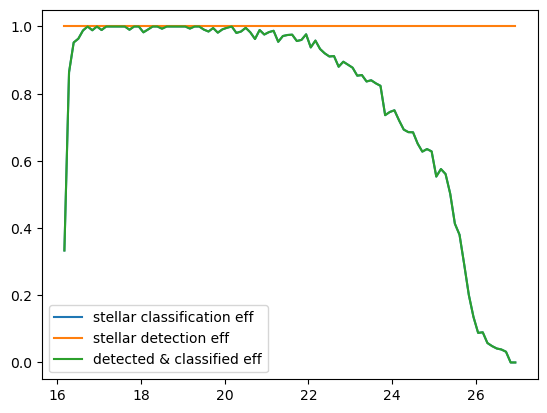

In [40]:
bins = np.linspace(16,27,100)
centers = (bins[1:]+bins[:-1])/2.

# Counts of true stars
ntot_truth, _ = np.histogram(true_stars['mag_corrected_r'],bins=bins)

# Counts of matched objects
#ntot, _ = np.histogram(df['truth_mag_r'],bins=bins)

# Counts of matched objects classified as stars
#ntot_star, _ = np.histogram(stars['truth_mag_r'],bins=bins)

# Counts of matched objects with truth class of stars
ntot_true_star, _ = np.histogram(true_stars['mag_corrected_r'],bins=bins)

# Counts of matched objects correctly classified as stars
nstar_class,_ = np.histogram(match_stars_class['mag_corrected_r'],bins=bins)

plt.plot(centers, nstar_class/ntot_true_star, label='stellar classification eff')  # matched objects correctly classified as stars / matched objects with truth class of stars
plt.plot(centers, ntot_true_star/ntot_truth, label='stellar detection eff')  # matched objects with truth class of stars / true stars
plt.plot(centers, nstar_class/ntot_truth, label='detected & classified eff')  # matched objects correctly classified as stars / true stars
plt.legend()

### photometric errors

In [41]:
maglim_r = hp.read_map('/home/sidneymau/WORK/satsim/supreme_dc2_dr6d_v3_r_maglim_psf_wmean.fits.gz')
delta_mag_r = np.histogram(true_stars['truth_mag_r']-maglim_r[hp.ang2pix(4096, 62, -37, lonlat=True)], bins=100)[1]
indices = np.digitize(true_stars['truth_mag_r']-maglim_r[hp.ang2pix(4096, 62, -37, lonlat=True)], delta_mag_r)
magerr_r = np.asarray([np.nanmedian(true_stars['magerr_r'][indices == idx]) for idx in np.unique(indices)])

from matplotlib.colors import LogNorm
# we are using `truth_mag_r` because we're using these photometric error models
# to generate simulations which will then be used to generate realistic photometry
plt.hist2d(true_stars['truth_mag_r']-maglim_r[hp.ang2pix(4096, 62, -37, lonlat=True)],np.log10(true_stars['magerr_r']),bins=100,norm=LogNorm(),range=[[-11, 3], [-4.1, 0.2]], cmap='binary')
plt.plot(delta_mag_r, np.log10(magerr_r), c='r')
plt.xlabel('delta mag (r)'); plt.ylabel('log mag err (r)')
plt.axhline(0.1085,ls='--',color='k',lw=2)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sidneymau/WORK/satsim/supreme_dc2_dr6d_v3_r_maglim_psf_wmean.fits.gz'